Load location

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

#we don't want to make plots with too less of data
IGNORE_PLOT_MIN = 5

#loc = input('Files location: ')
# if not loc: loc = '../data/raw_metadata'
loc = '../data/raw_metadata'
figures_loc = '../data/figures'

#define parsers functions
def time_pars(c): return datetime.datetime(int(c[6:10]), int(c[3:5]), int(c[0:2]), int(c[11:13]), int(c[14:16]), int(c[17:19]))
def bool_pars(c): return 1 if c == 'True' else 0
    
data = dict()
processed = dict()
    
#process files
for file_name in os.listdir(loc):
    if not file_name.endswith('.csv'):
        continue
    with open(os.path.join(loc, file_name), 'r') as file:
        data[file_name[:-4]] = pd.read_csv(file, parse_dates=[0, 1, 2], date_parser=time_pars, index_col=0, 
                                           converters={'Metadata changed': bool_pars, 'Binary changed': bool_pars})

#ddata.keys() is not sorted, but we want plots to appear in alphabetical order
data_names = sorted(data.keys())

Select resample time delta and plot

Select time period:
['GTFS_KRK_A.zip', 'GTFS_KRK_T.zip', 'ServiceAlerts_A.pb', 'ServiceAlerts_T.pb', 'TripUpdates_A.pb', 'TripUpdates_T.pb', 'VehiclePositions_A.pb', 'VehiclePositions_T.pb']


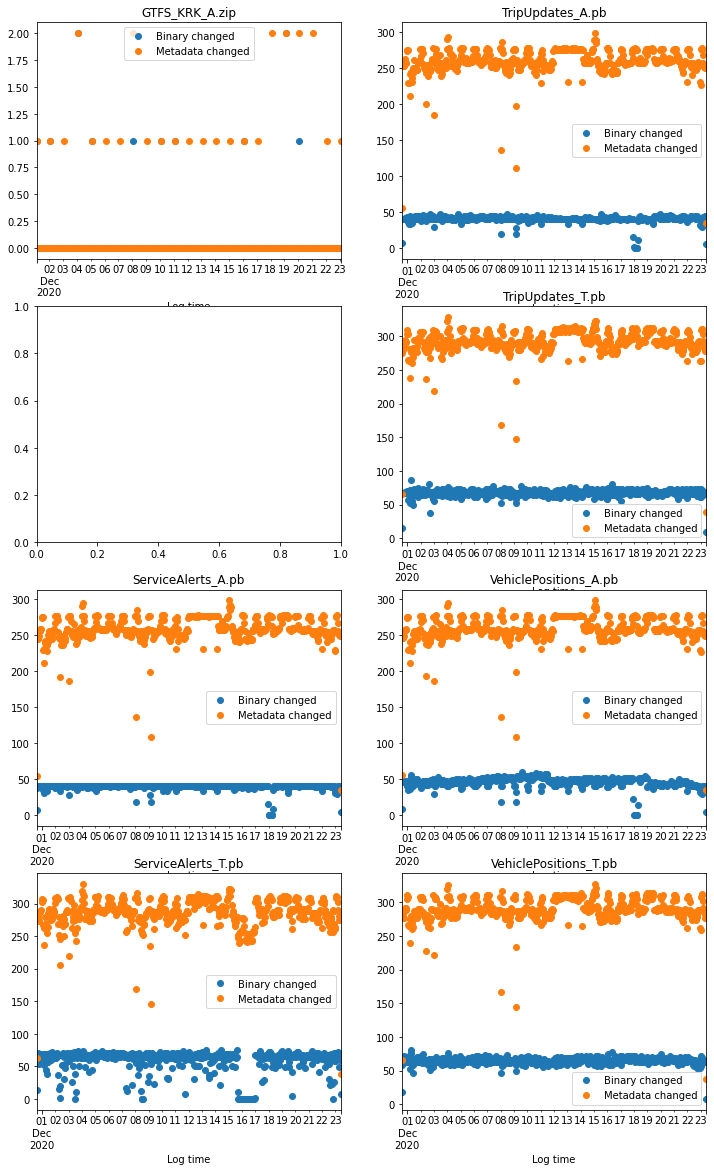

In [6]:
fr = input('Select time period:')
if not fr: fr = '1H'
    
fig, axs = plt.subplots(4, 2, figsize=(12, 20))

print(data_names)
for i, to_plot in enumerate(data_names):
    temp_df = data[to_plot]
    if len(temp_df.index) < IGNORE_PLOT_MIN:
        continue
    temp_df = temp_df.filter(items=['Binary changed', 'Metadata changed']).resample(fr).sum()
    temp_df.plot(style='o',title=to_plot, ax=axs[i%4, i//4])#.locator_params(integer=True)
del temp_df
plt.savefig(os.path.join(figures_loc, f'binary_vs_meta_changes_freq={fr}.png'),
            facecolor='w')
plt.show()

Plot suffix sums

In [7]:
for to_plot in data_names:
    temp_df = data[to_plot]
    if len(temp_df.index) < IGNORE_PLOT_MIN:# or to_plot in processed:
        continue

    temp_df = temp_df[temp_df['Binary changed'] > 0].filter([])
    total = len(temp_df.index) #save total number of updates to calculate %s
    temp_df['Time (s)'] = temp_df.index #we want to calculate diff() on index, so we have to make copy of it (diff() does not work on indexes)
    temp_df = temp_df.diff().iloc[1:].set_index('Time (s)') #caclulate diff(), throw away the first value and set it as index
    temp_df.insert(column='Quantity', value=1, loc=0)
    temp_df = temp_df.resample('1S').sum()
    temp_df.index = temp_df.index.map(lambda x: int(x.total_seconds())) #convert time stored in timedeltas into ints
    suff_sum = 0
    for index in reversed(temp_df.index):
        suff_sum += temp_df.loc[index, 'Quantity'] #use suffix sum
        temp_df.loc[index, 'Quantity'] = 1 - suff_sum / total #calculate %
    processed[to_plot] = temp_df
del temp_df
#code above takes a few sec to run, so we store its result in processed[] so we don't have to run it again


Plot start (s): 
Plot end (s): 


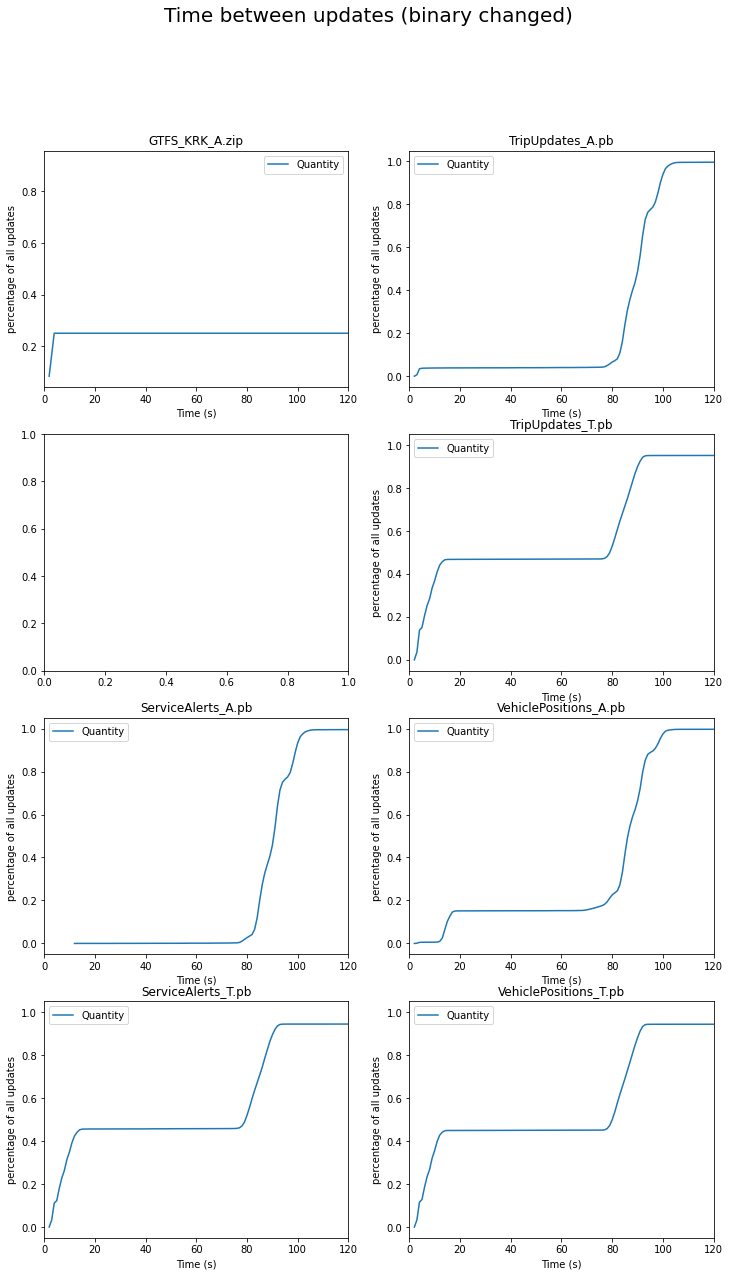

In [14]:
mn = input('Plot start (s): ')
if not mn or int(mn) < 0: mn = 0
else: mn = int(mn)
mx = input('Plot end (s): ')
if not mx or int(mx) < 0: mx = 120
else: mx = int(mx)

fig, axs = plt.subplots(4, 2, figsize=(12, 20))
fig.suptitle('Time between updates (binary changed)', fontsize=20)

for i, to_plot in enumerate(data_names):
    if len(data[to_plot].index) < IGNORE_PLOT_MIN:
        continue
        
    ax = axs[i%4, i//4]
    processed[to_plot].plot(title=to_plot, xlim = (mn, mx), ax=ax)
    ax.set_ylabel('percentage of all updates')

plt.savefig(os.path.join(figures_loc, f'time_between_updates.png'), facecolor='w')
plt.show()